<a href="https://colab.research.google.com/github/KOdin2/Machine-learning/blob/main/Random_forest_Binary_classifier_assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import io
import pandas as pd
import sklearn
import csv


#####
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn import ensemble

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline


In [132]:
from google.colab import files
uploaded = files.upload()

Saving Aluminium_3-8Zor_ffs_dataset.csv to Aluminium_3-8Zor_ffs_dataset (1).csv
Saving Aluminium_8-25WF_ffs_dataset.csv to Aluminium_8-25WF_ffs_dataset (1).csv
Saving Aluminium_25-75WF_dataset.csv to Aluminium_25-75WF_dataset (1).csv
Saving Aluminium_FM_dataset.csv to Aluminium_FM_dataset (1).csv
Saving Brass_3-8Zor_ffs_dataset.csv to Brass_3-8Zor_ffs_dataset (1).csv
Saving Brass_BIM_dataset.csv to Brass_BIM_dataset (1).csv
Saving SSteel_8-25Zur_datset.csv to SSteel_8-25Zur_datset (1).csv
Saving SSteel_25-75WF_dataset.csv to SSteel_25-75WF_dataset (1).csv
Saving Zinc_8-25WF_ffs_dataset.csv to Zinc_8-25WF_ffs_dataset (1).csv


Best measurements to use for classification are:

precision,
recall,
accuracy,
f1,
roc_auc


In [133]:
#@title Functions

def grid_search_RF_function(x_train, y_train, feature_combinations, varible_combinations, number_of_cv_folds, best_results, x_train_df):

  Algorithm = "Random Forest"
  forest_reg = RandomForestClassifier(random_state=0)

  #Set up parameter grid
  param_grid = [
      {'bootstrap': [False], 'n_estimators': varible_combinations, 'max_features': feature_combinations}
  ]

  #scoring_type can be used to choose what method to compare the models on
  scoring_type = 'f1'

  print("Number of fold: " + str(number_of_cv_folds))
  
  grid_search = GridSearchCV(estimator= forest_reg, param_grid= param_grid,  cv= number_of_cv_folds , scoring=scoring_type,  return_train_score=True, n_jobs=-1)

  grid_search.fit(X= x_train, y= y_train)

  best_paramater = grid_search.best_params_

  print("[INFO]Best paramter: " + str(best_paramater))

  #find best score and round to 2dp
  best_accuracy = round(grid_search.best_score_,2)

  ######Calculate the features ranked as best dependent on grid search result#######

  #This code works out the best features from the parameters given above
  estimator = RandomForestClassifier(random_state=0, n_estimators =  best_paramater['n_estimators'], bootstrap = best_paramater['bootstrap'])

  selector = RFECV(estimator, step=1, cv= number_of_cv_folds, scoring = scoring_type)
  selector = selector.fit(x_train, y_train)

  ranked_features = selector.ranking_
  print("[INFO] Rnk of all features: " + str(ranked_features))

  #create list to store important features
  most_important_features = []

  #aqrure the index of all values which have 1 as their ranking
  feat_index = np.where(ranked_features == 1)
  print("[INFO] Rank 1 features index: " + str(feat_index))
  #append the best featurees to the list
  for value in feat_index:
    most_important_features.append(x_train_df.columns[value])

  #Append results to 
  best_results.append([ Algorithm,
                       best_paramater['n_estimators'],                     
                      scoring_type,
                      best_accuracy,
                      best_paramater['max_features'],
                      
  ])

  best_results.append([
                      most_important_features])
           
  return best_results.append

def testing_combination_arrays(x_train_varible, max_varible):

  x_train_columns = x_train_varible.shape[1]
  x_train_columns = int(round((x_train_columns/2),0))
  print("[INFO] Number of max features: " + str(x_train_columns))
  feature_combinations = [] 
  varible_combinations = []

  a = 1
  for value in range(0,x_train_columns):
    feature_combinations.append(a) 
    a+=1 

  b = 1
  for value in range(0, max_varible):
    varible_combinations.append(b) 
    b+=1

  return feature_combinations, varible_combinations


def calculate_cross_validation_value(y_train):

  arr = y_train.to_numpy()
  bin_arr = np.bincount(arr)
  return bin_arr.min()

In [134]:
#@title Grid search with a given x and y and combination of varible. Also number of cv fold cross validation

def grid_search_RF_function(x_train, y_train, Varible_list_1 , Varible_list_2, number_of_cv_folds):

  best_model_details =[]
  #create mdoel
  Algorithm = "Random Forest"
  model = RandomForestClassifier(random_state=0,bootstrap = False)  
  min_max = MinMaxScaler()
  
  #Create a pipline, which first will train on max and min and then transform the output
  pipe = Pipeline(steps = [
                               ("min_max" , min_max ),
                               
                               ("model" , model )
                               
  ])

  #Set up parameter grid
  param_grid = [
      {'model__n_estimators': Varible_list_1, 'model__max_features': Varible_list_2}
  ]

  #scoring_type can be used to choose what method to compare the models on
  scoring_type = 'f1'
 
  grid_search = GridSearchCV(estimator= pipe, param_grid= param_grid,  cv= number_of_cv_folds , scoring=scoring_type,  return_train_score=True, n_jobs=-1)

  grid_search.fit(X= x_train, y= y_train)

  #Aquire best parameter for model
  best_paramater = grid_search.best_params_
  print("[INFO] Best parameter: " + str(best_paramater))

  #find best score and round to 4dp
  best_accuracy = round(grid_search.best_score_,4)
  print("[INFO] Best score: " + str(best_accuracy))

  #Append results to 
  best_model_details.append([ Algorithm,
                        scoring_type,
                        best_accuracy,
                        best_paramater['model__n_estimators'],
                        best_paramater['model__max_features'],
                        str(number_of_cv_folds),
                      
  ])


  return best_model_details, best_paramater

In [135]:
def reduce_input(x_train, y_train, number_of_cv_folds, best_paramater, x_train_df):

  end_of_reduction = False
  #create the best best model and fit with data to see inputs used
  #create mdoel
  Algorithm = "Random Forest"
  model = RandomForestClassifier(random_state=0,bootstrap = False, n_estimators = best_paramater['model__n_estimators'],max_features = best_paramater['model__max_features'])  
  min_max = MinMaxScaler()
  
  pipe = Pipeline(steps = [
                               ("min_max" , min_max ),
                               
                               ("model" , model )
                               
  ])

  pipe = pipe.fit(x_train, y_train)

  bad_input = []

  #Aquire the festes that are important
  Feature_importance = model.feature_importances_
  #copy dataframe so values can be removed
  updated_x_train = x_train_df.copy()

  a = 0
  #Every feauture which has 0 value is removed
  for value in Feature_importance:
    if(value == 0):
      bad_input.append(x_train_df.columns[a])
    a+=1
  
  print("[INFO] Number of removed inputs: " + str(len(bad_input)))
  if(len(bad_input)==0):
    print("[INFO] Inputs can not be further reduced!")
    end_of_reduction = True

  for value in bad_input:
    updated_x_train = updated_x_train.drop([value], axis='columns')

  updated_x_train_df = updated_x_train.copy()

  #### Plot results of important features
  importance = np.abs(model.feature_importances_)
  feature_names = np.array(x_train_df.columns)
  f, ax = plt.subplots(figsize=(30,5))
  plt.bar(height=importance, x=feature_names, )
  plt.title("Feature importances via feature_importances_ for Random Forest")
  plt.xticks(rotation='vertical')
  plt.show()


  return end_of_reduction, updated_x_train_df, updated_x_train_df



def best_model_test(x_train, y_train, number_of_cv_folds, best_paramater, best_results, x_train_df):

  model_check = []

  #create mdoel
  Algorithm = "Random Forest"
  model = RandomForestClassifier(random_state=0,bootstrap = False, n_estimators = best_paramater['model__n_estimators'],max_features = best_paramater['model__max_features'])  
  min_max = MinMaxScaler()
  
  pipe = Pipeline(steps = [
                               ("min_max" , min_max ),
                               
                               ("model" , model )
                               
  ])

  y_train_pred = cross_val_predict(pipe, x_train, y_train, cv=number_of_cv_folds)

  conf = confusion_matrix(y_train, y_train_pred)
  print(conf)
  f1        = round(f1_score(y_train, y_train_pred), 4)
  precision = round(precision_score(y_train, y_train_pred), 4)
  recall    = round(recall_score(y_train, y_train_pred), 4)

  print("F1 score\tPurity\t\tRecovery")
  print(str(f1) + "\t\t" + str(precision) + "\t\t" + str(recall) + "\n\n")
    
  model_check.append([f1, precision, recall, conf, len(x_train.columns),  str(number_of_cv_folds)])


  return model_check

In [136]:
header = ["Algorithm", "Scoring type", "Score", "Number of esitmators",  "Max features", "Cross-validation setting"]
model_check_header = ["f1", "Purity", "Recovery", "Confusion matrix", "Number of inputs", "Cross-validation setting"]
best_features_header = ["Imporant Features"]

File uploaded: Aluminium_3-8Zor_ffs_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=13, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 21, 'model__n_estimators': 19}
[INFO] Best score: 0.8718
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 26


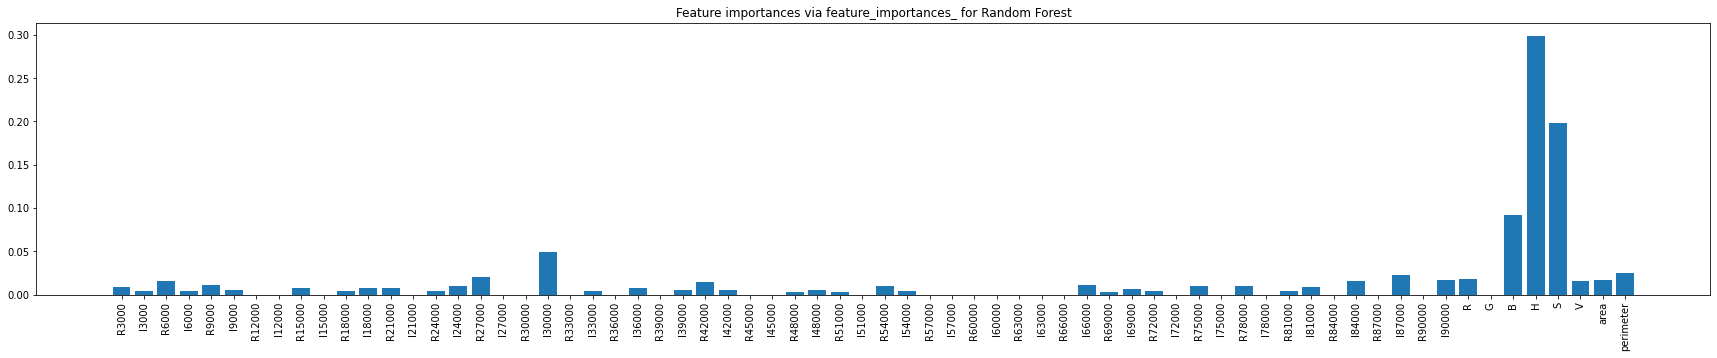

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 3}
[INFO] Best score: 0.8974
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 27


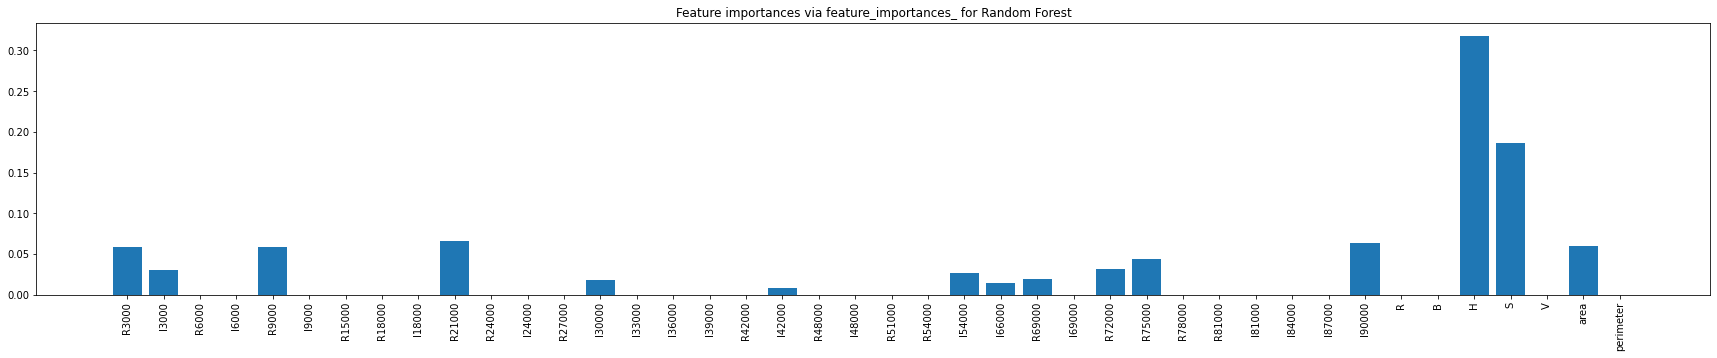

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 3, 'model__n_estimators': 5}
[INFO] Best score: 0.9487
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 5


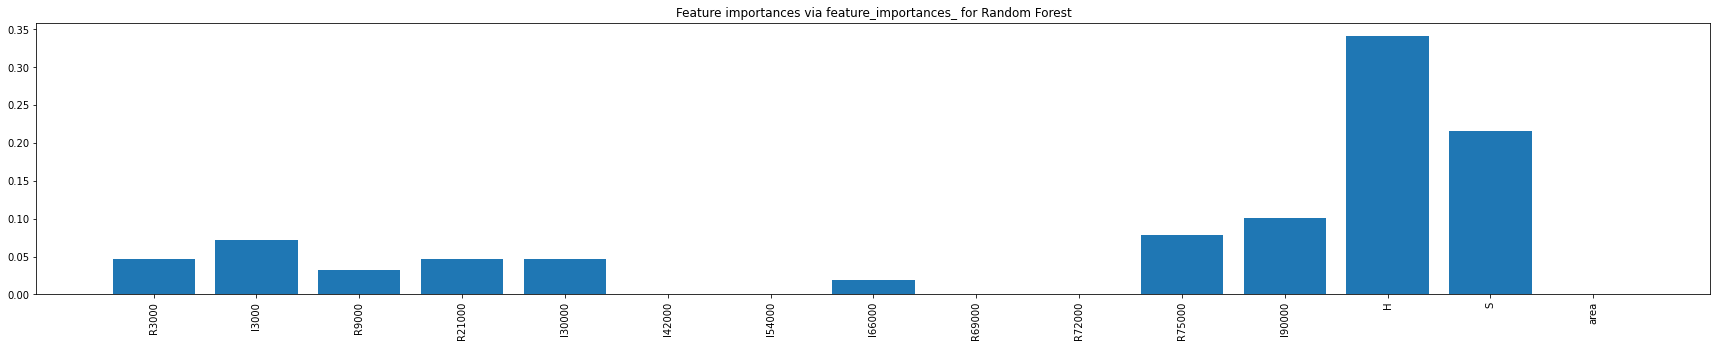

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 6, 'model__n_estimators': 5}
[INFO] Best score: 0.9103
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!


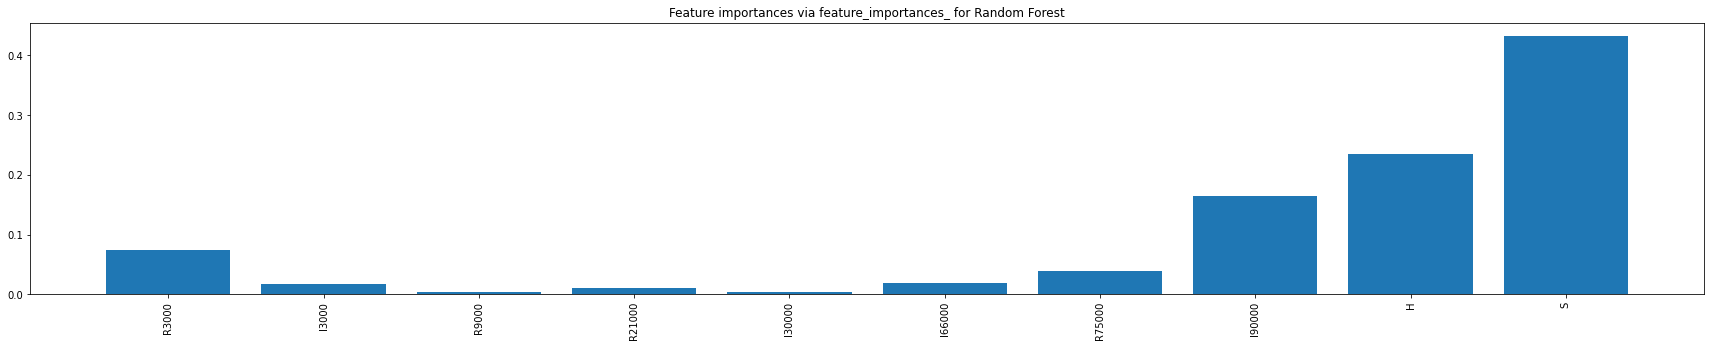

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 6, 'model__n_estimators': 5}
[INFO] Best score: 0.9103
[[33  4]
 [ 0 13]]
F1 score	Purity		Recovery
0.8667		0.7647		1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Aluminium_8-25WF_ffs_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=23, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 29, 'model__n_estimators': 13}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 30


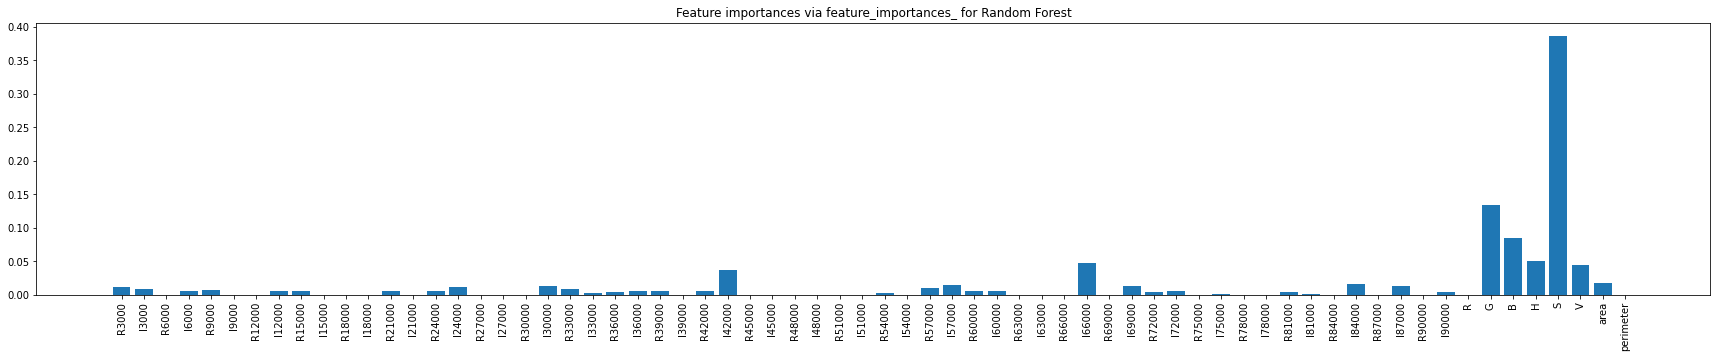

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 15, 'model__n_estimators': 13}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 8


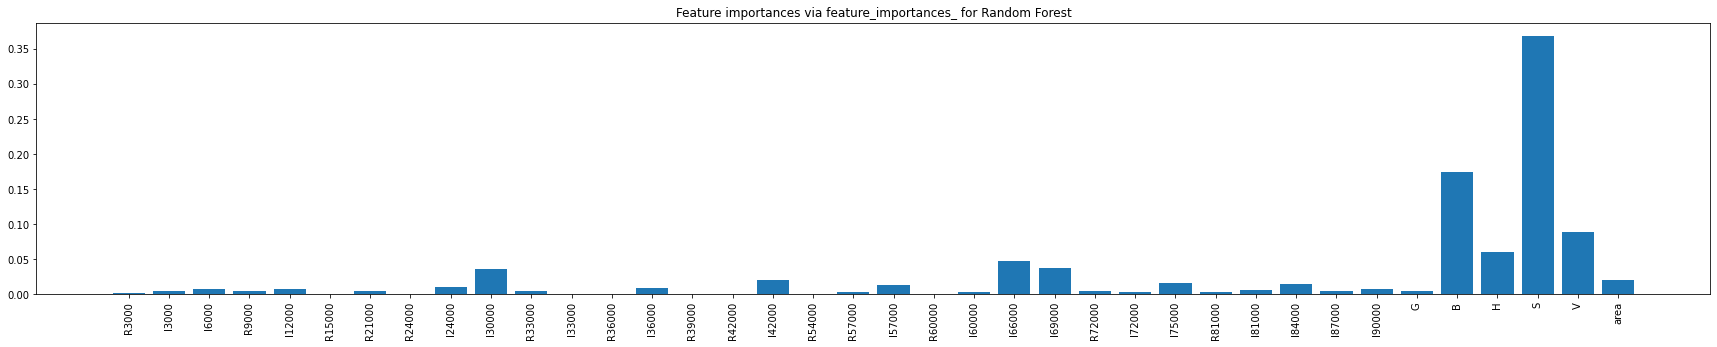

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 17}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 3


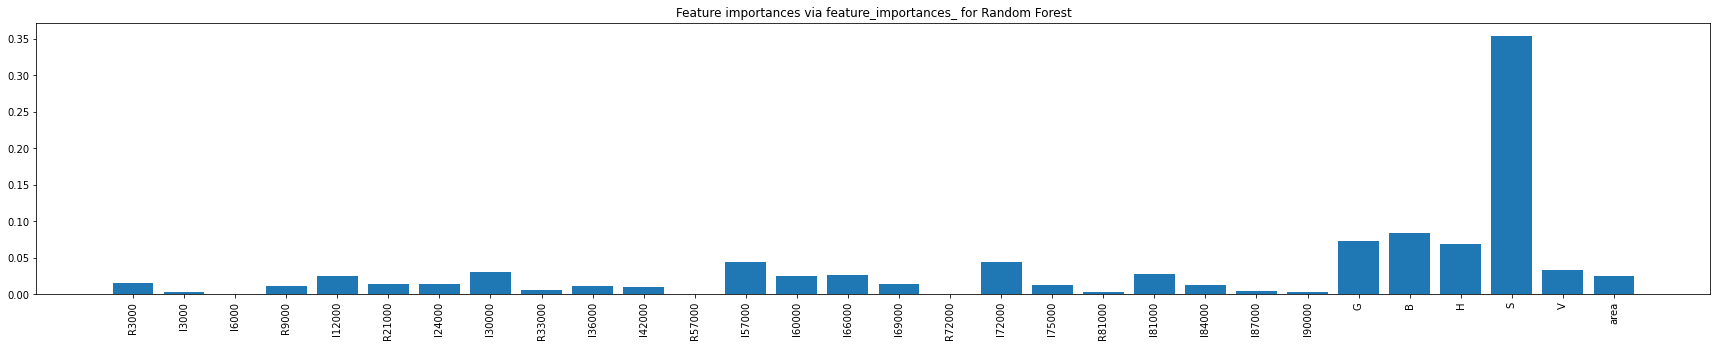

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 3}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 13


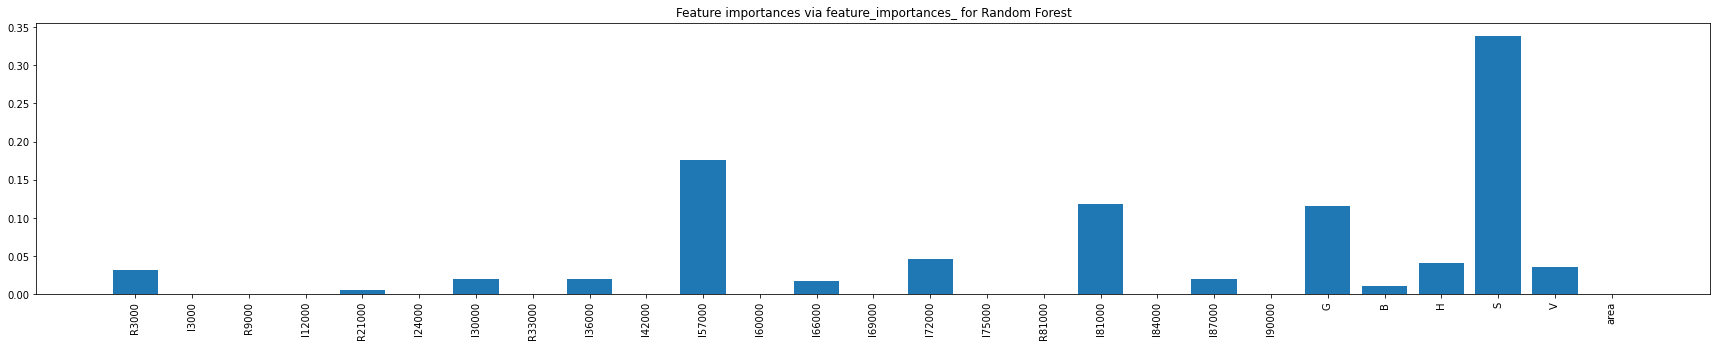

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 3, 'model__n_estimators': 7}
[INFO] Best score: 0.9275
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!


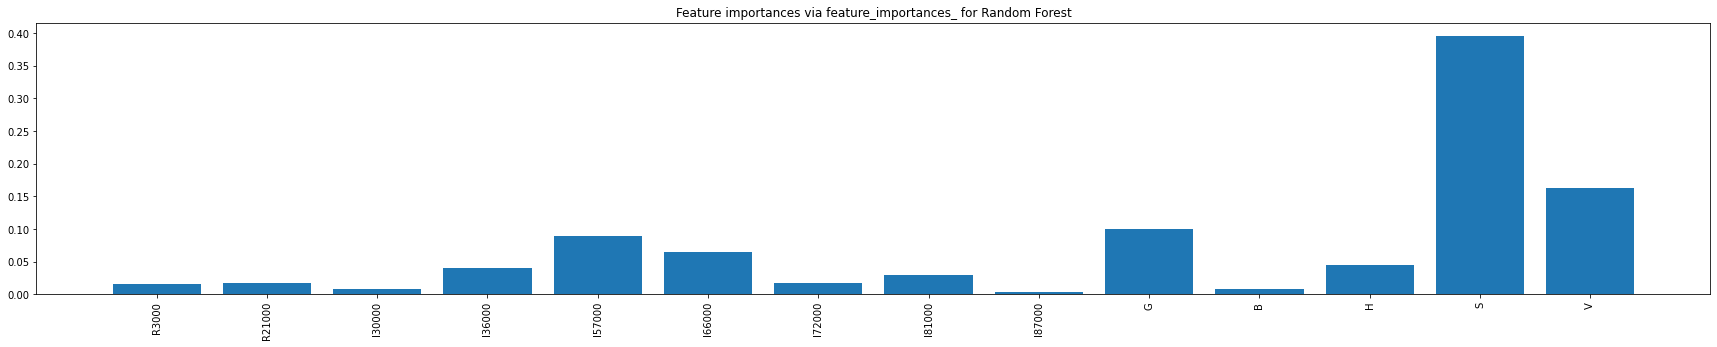

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 3, 'model__n_estimators': 7}
[INFO] Best score: 0.9275
[[21  2]
 [ 1 25]]
F1 score	Purity		Recovery
0.9434		0.9259		0.9615


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Aluminium_25-75WF_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=13, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 9}
[INFO] Best score: 0.7179
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 21


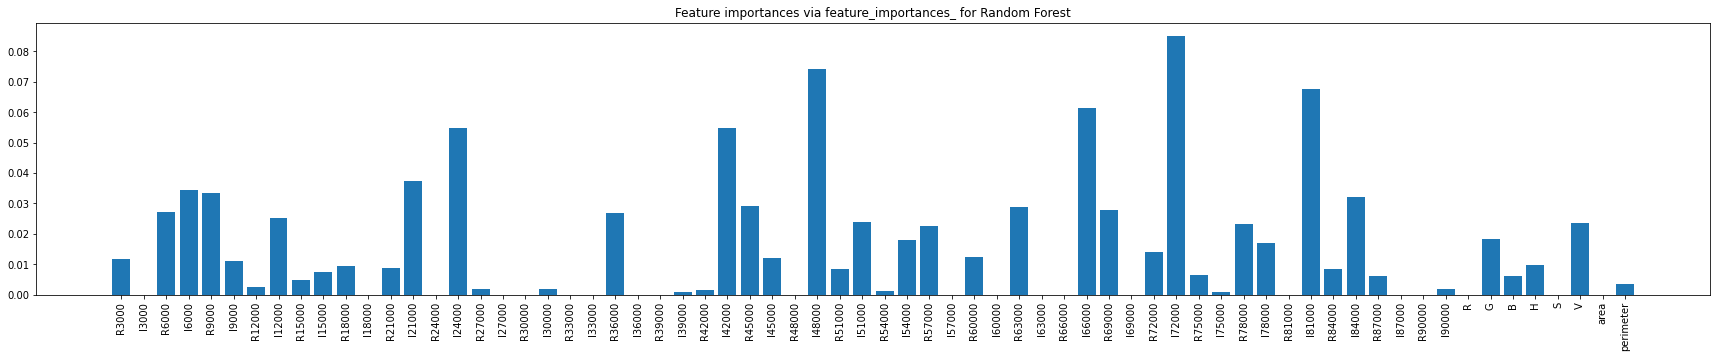

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 2}
[INFO] Best score: 0.8205
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 36


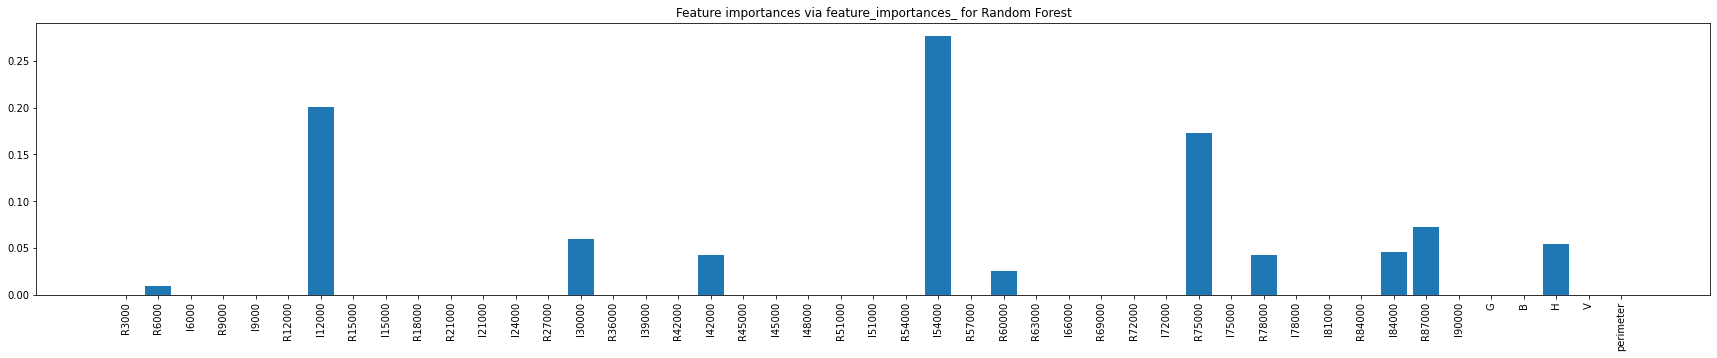

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 1}
[INFO] Best score: 0.7949
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 6


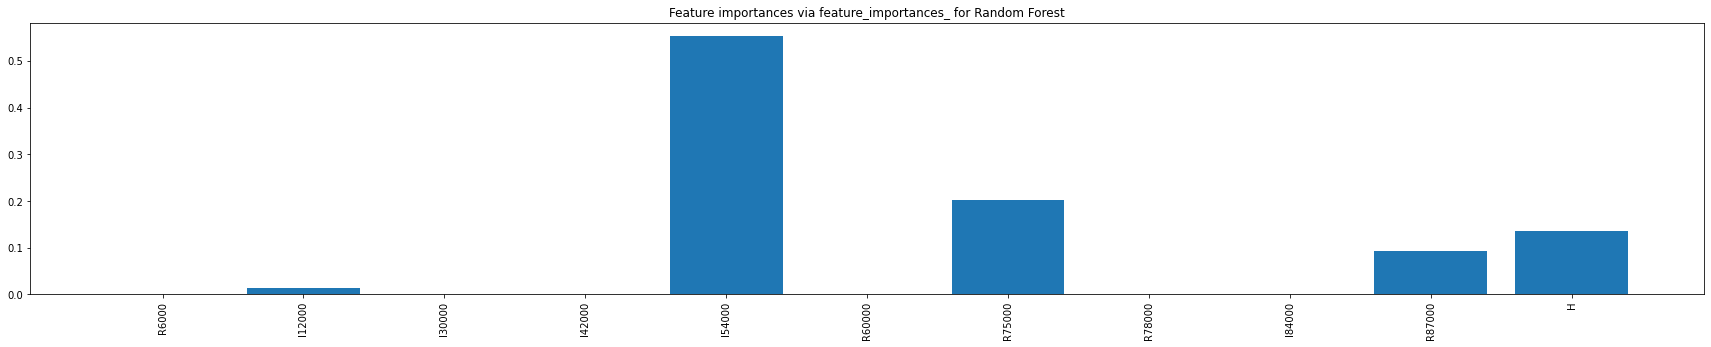

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 18}
[INFO] Best score: 0.8205
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!


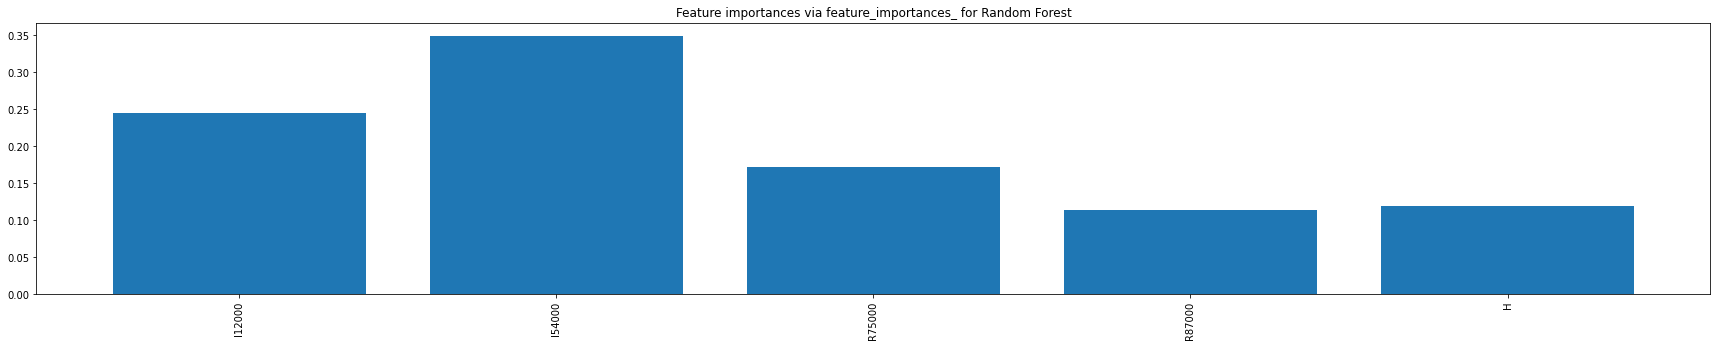

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 18}
[INFO] Best score: 0.8205
[[27  1]
 [ 2 11]]
F1 score	Purity		Recovery
0.88		0.9167		0.8462


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Aluminium_FM_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=19, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 12, 'model__n_estimators': 1}
[INFO] Best score: 0.9825
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 64


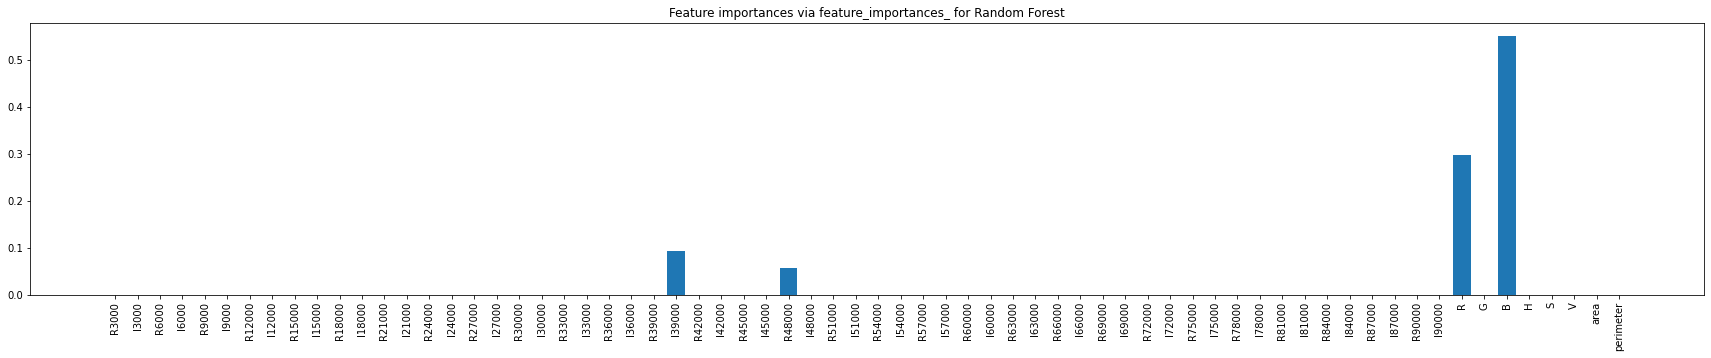

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 1}
[INFO] Best score: 0.9825
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 1


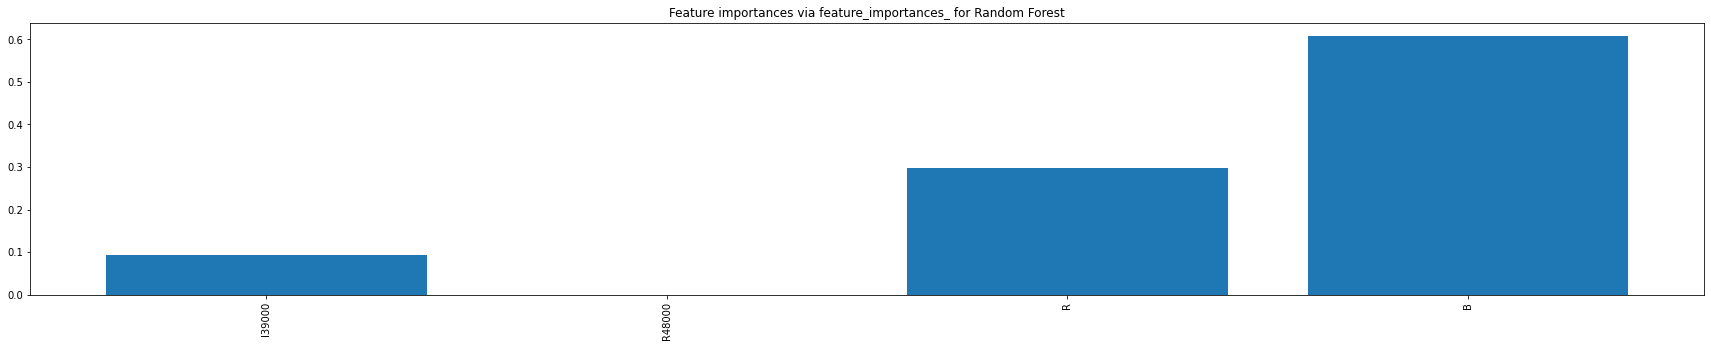

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 2}
[INFO] Best score: 0.9649
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!


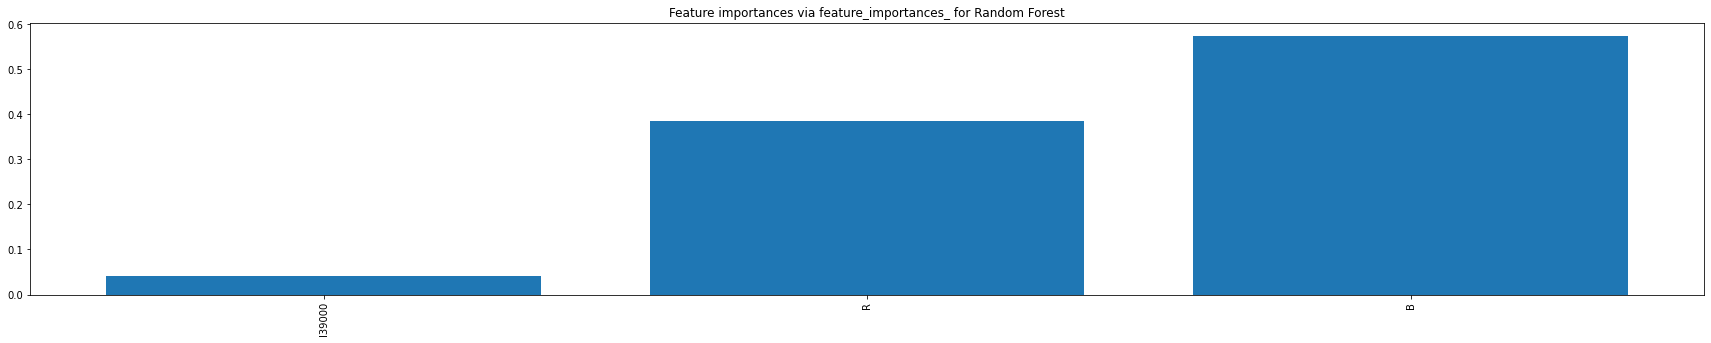

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 2}
[INFO] Best score: 0.9649
[[19  0]
 [ 2 29]]
F1 score	Purity		Recovery
0.9667		1.0		0.9355


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Brass_3-8Zor_ffs_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=18, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 30, 'model__n_estimators': 1}
[INFO] Best score: 0.7407
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 62


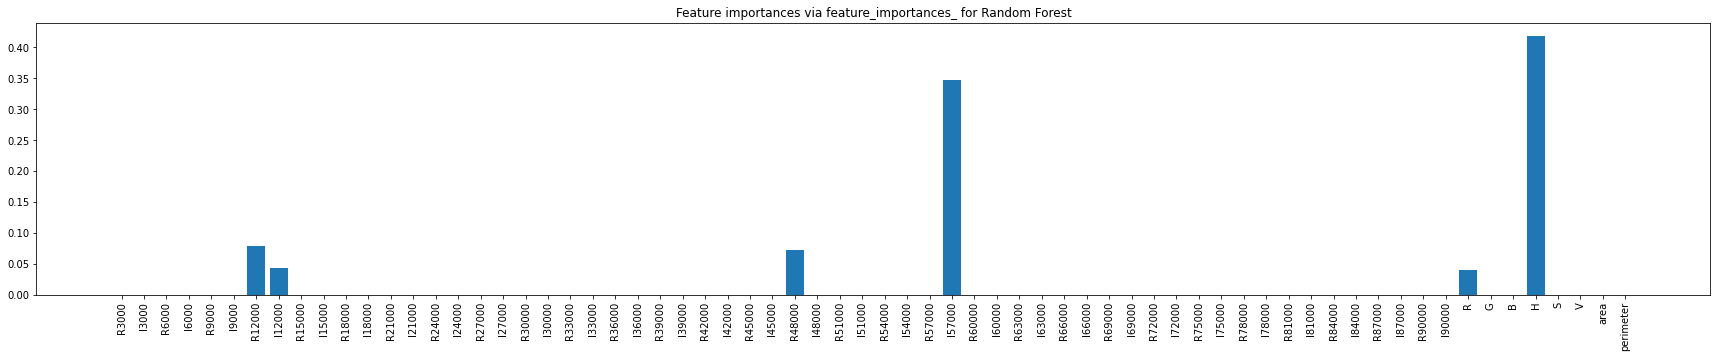

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 3}
[INFO] Best score: 0.7593
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!


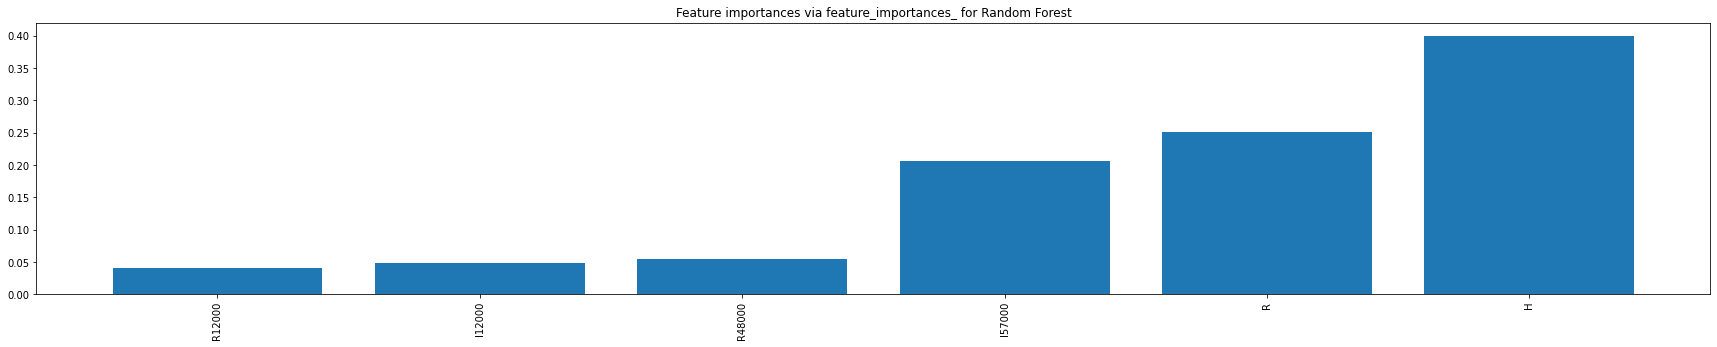

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 3}
[INFO] Best score: 0.7593
[[27  5]
 [ 3 15]]
F1 score	Purity		Recovery
0.7895		0.75		0.8333


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Brass_BIM_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=17, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 20, 'model__n_estimators': 8}
[INFO] Best score: 0.8569
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 23


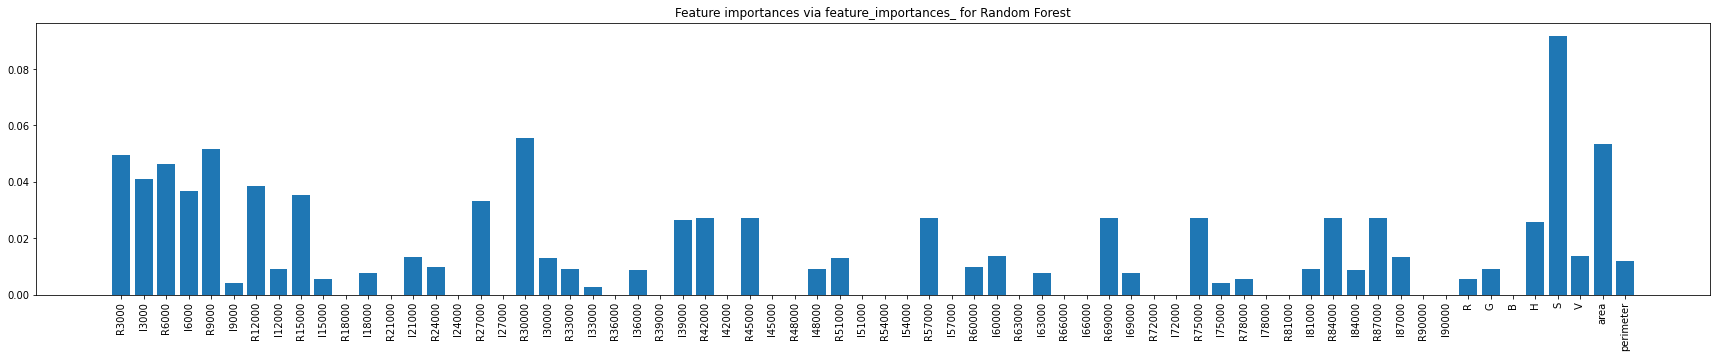

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 11, 'model__n_estimators': 15}
[INFO] Best score: 0.8569
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 4


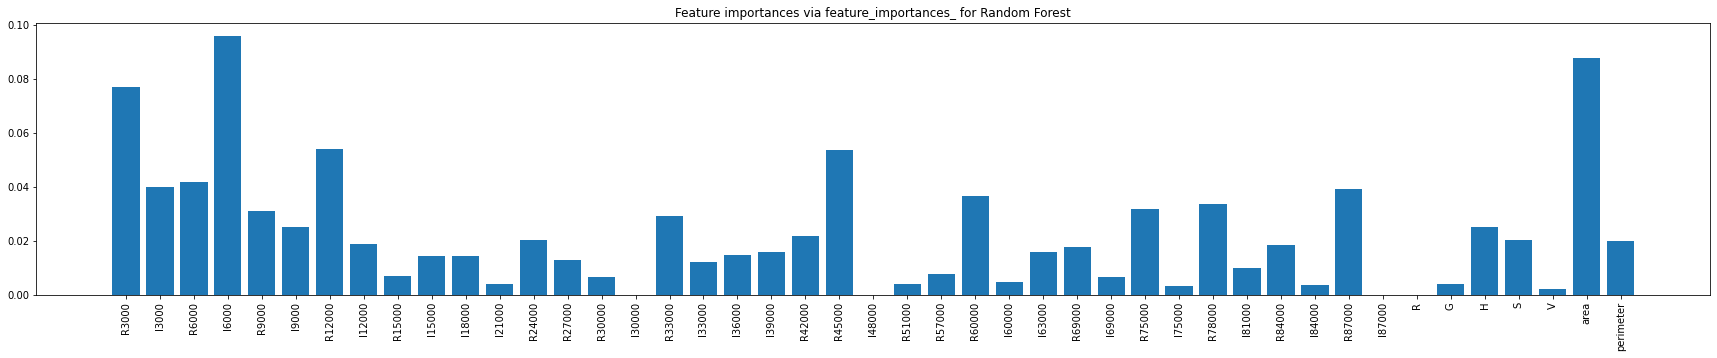

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 26, 'model__n_estimators': 1}
[INFO] Best score: 0.8608
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 32


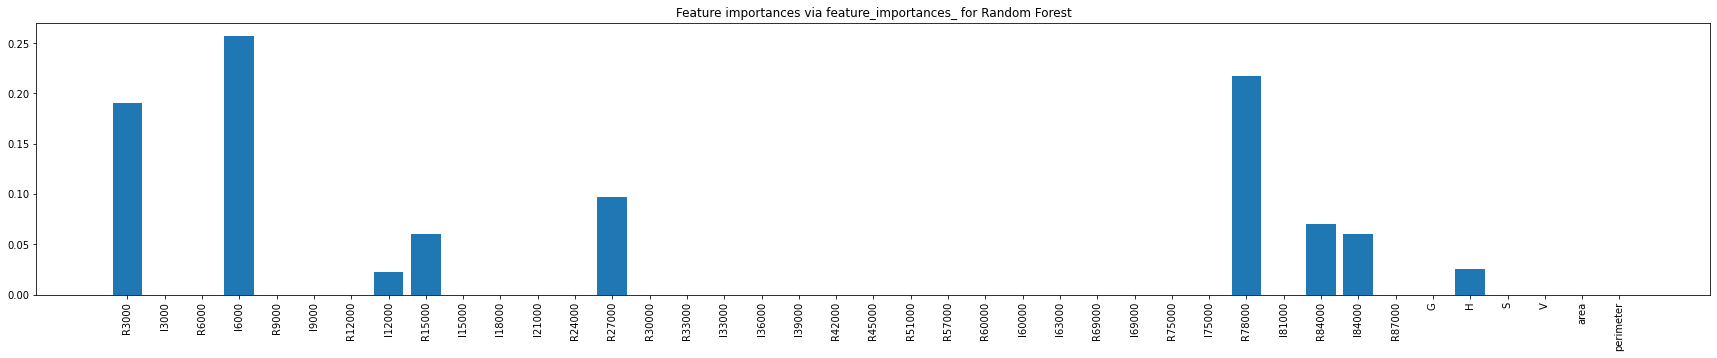

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 4, 'model__n_estimators': 1}
[INFO] Best score: 0.8902
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 2


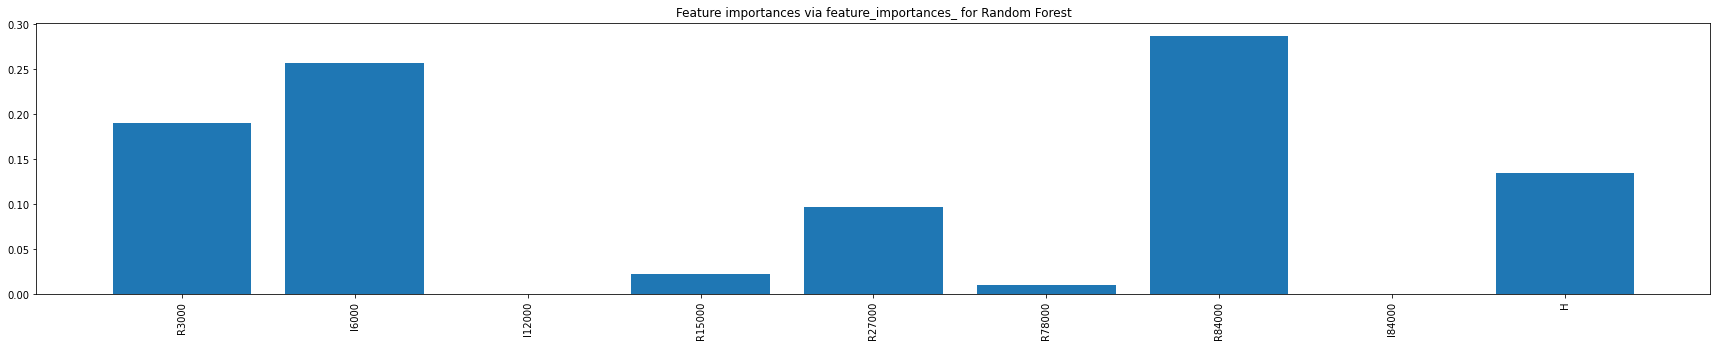

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 12}
[INFO] Best score: 0.8353
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!


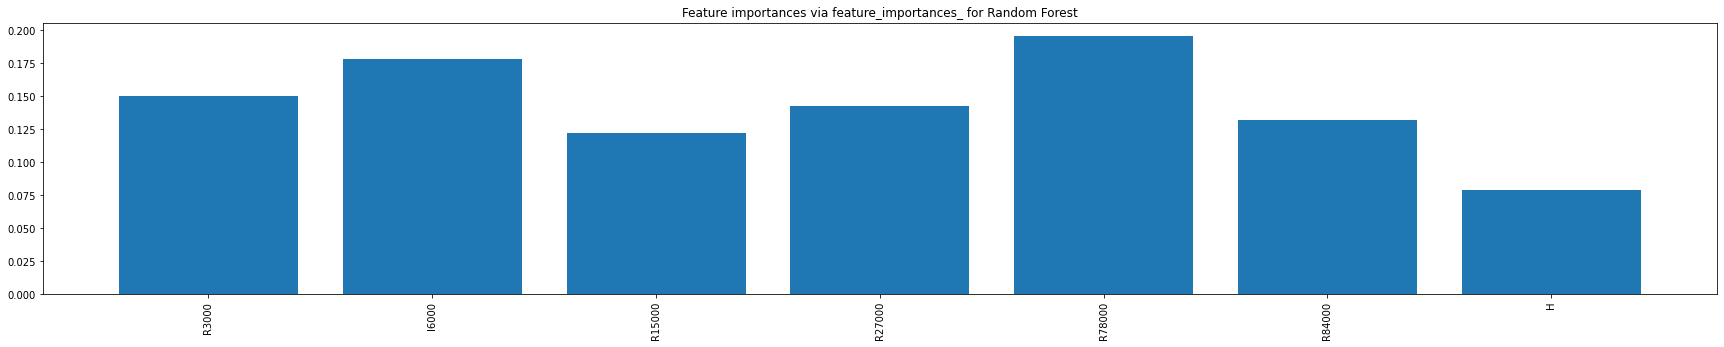

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 12}
[INFO] Best score: 0.8353
[[10  7]
 [ 4 28]]
F1 score	Purity		Recovery
0.8358		0.8		0.875


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: SSteel_8-25Zur_datset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=17, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 18, 'model__n_estimators': 13}
[INFO] Best score: 0.9765
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 32


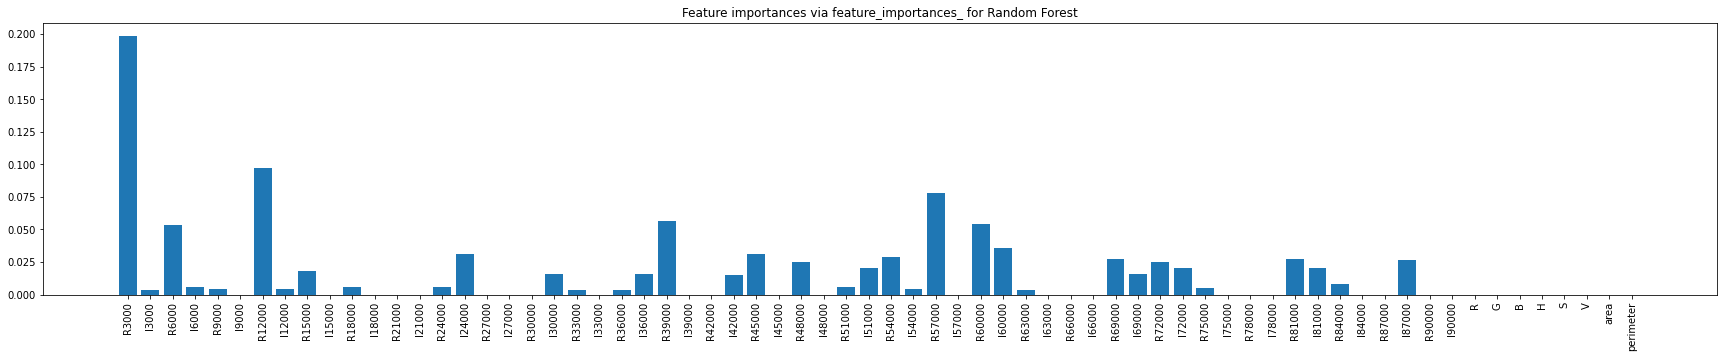

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 19, 'model__n_estimators': 1}
[INFO] Best score: 0.9882
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 32


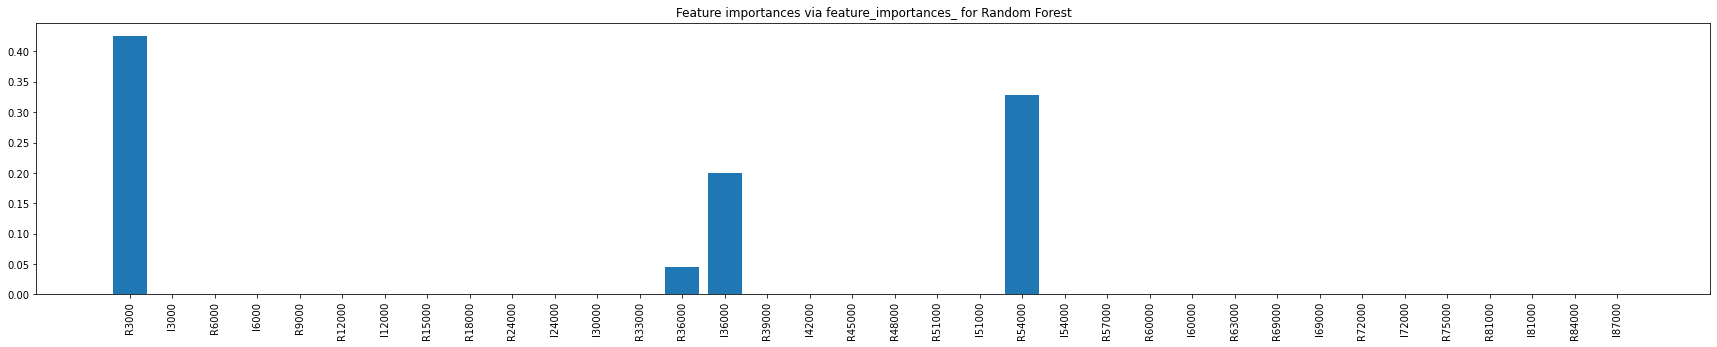

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 3}
[INFO] Best score: 0.9882
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!


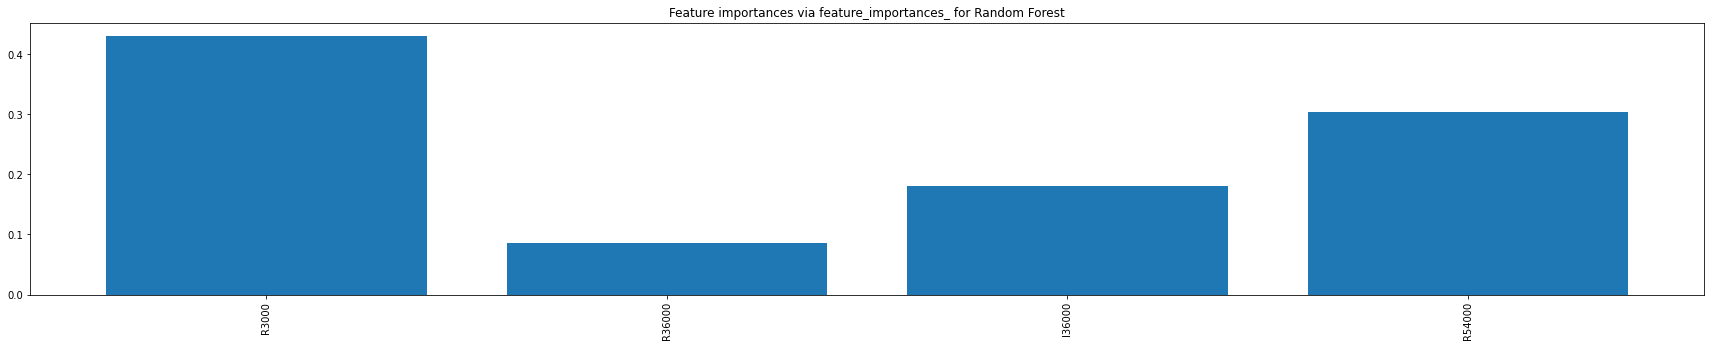

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 3}
[INFO] Best score: 0.9882
[[16  1]
 [ 0 33]]
F1 score	Purity		Recovery
0.9851		0.9706		1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: SSteel_25-75WF_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=14, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 2, 'model__n_estimators': 19}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 19


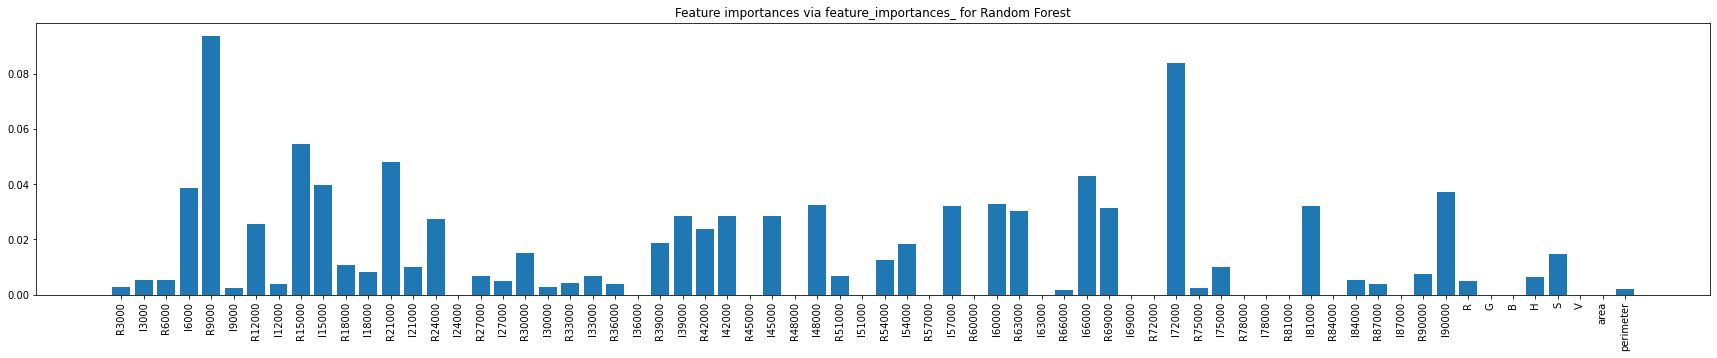

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 10}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 19


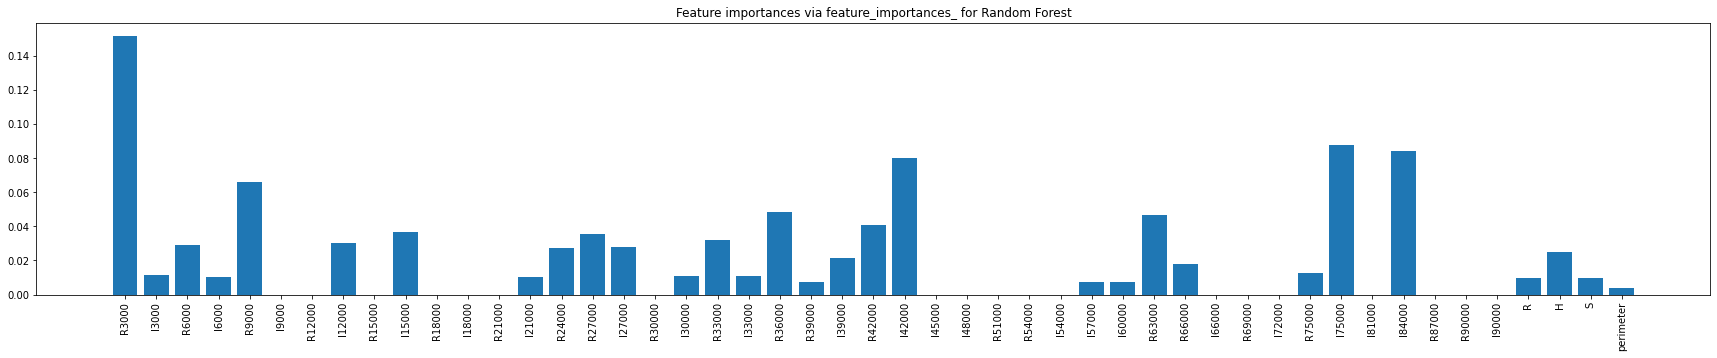

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 7}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 7


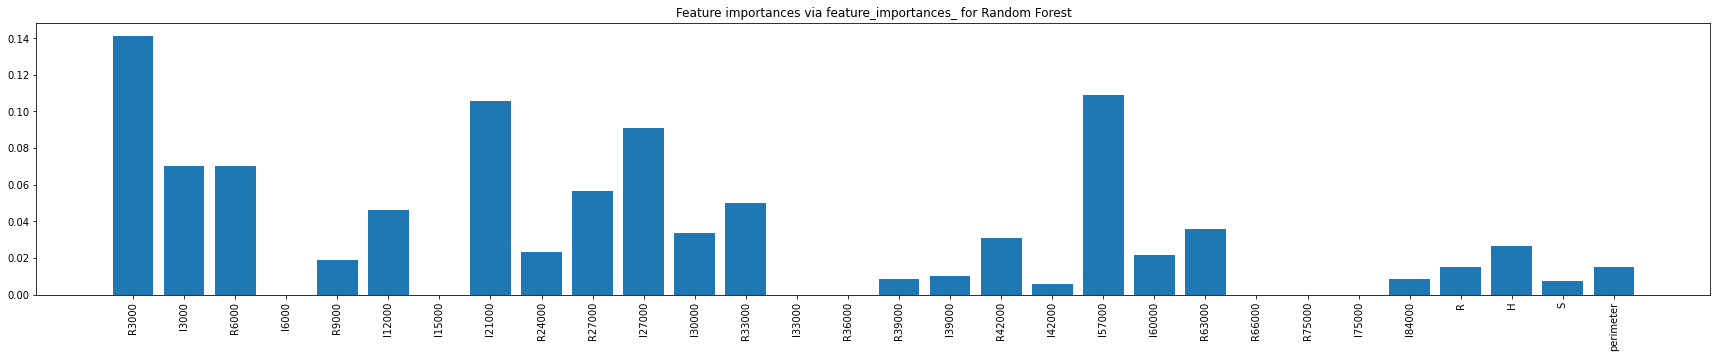

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 6}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 8


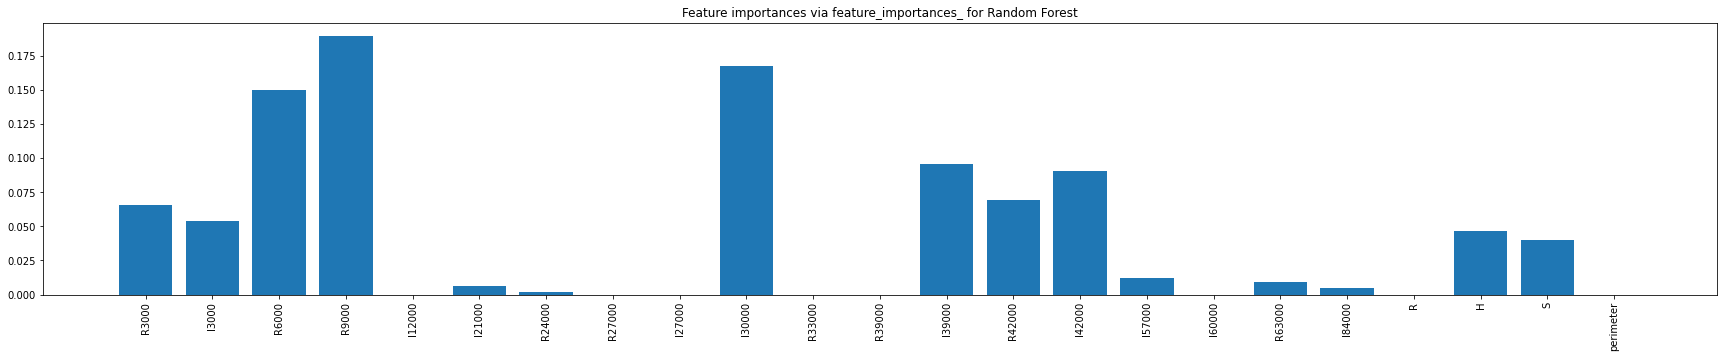

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 2}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 7


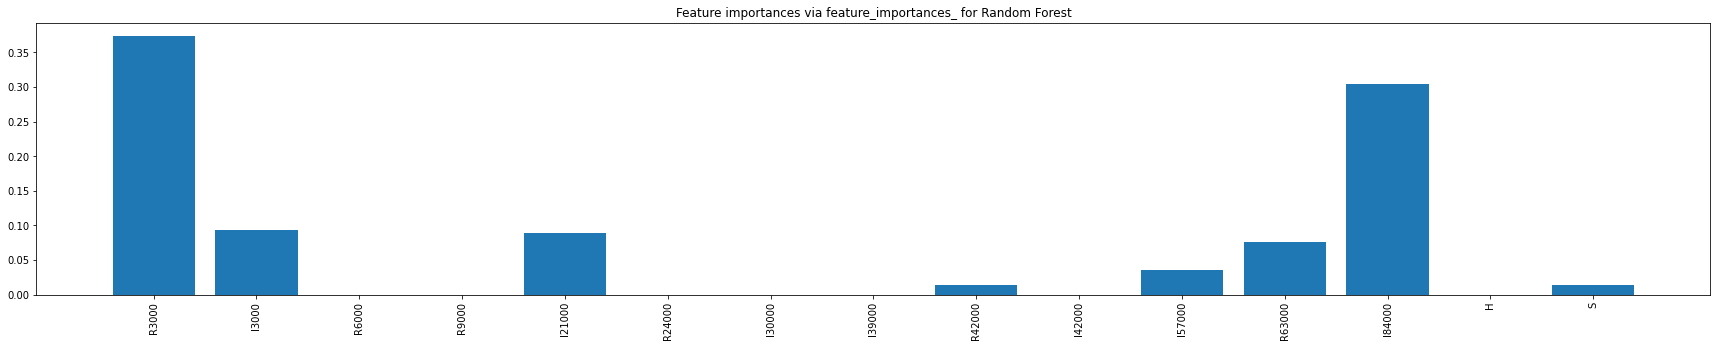

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 12}
[INFO] Best score: 1.0
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!


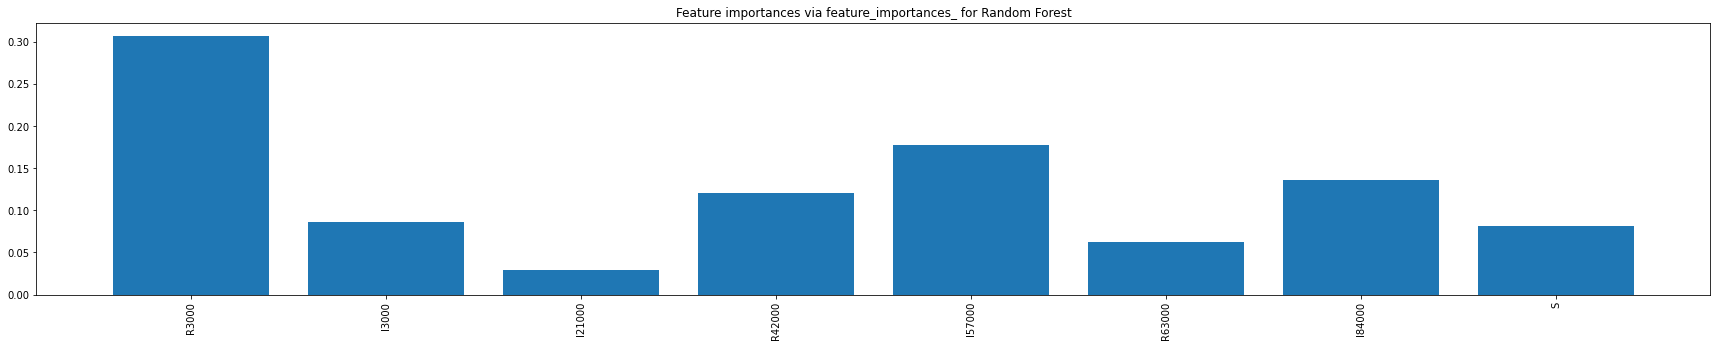

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 1, 'model__n_estimators': 12}
[INFO] Best score: 1.0
[[27  0]
 [ 0 14]]
F1 score	Purity		Recovery
1.0		1.0		1.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File uploaded: Zinc_8-25WF_ffs_dataset.csv
[INFO] Number of CV folds: StratifiedKFold(n_splits=21, random_state=None, shuffle=False)
[INFO] Number of max features: 34
[INFO] N_estimators combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[INFO] max_feature combinations: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 34, 'model__n_estimators': 5}
[INFO] Best score: 0.8571
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 48


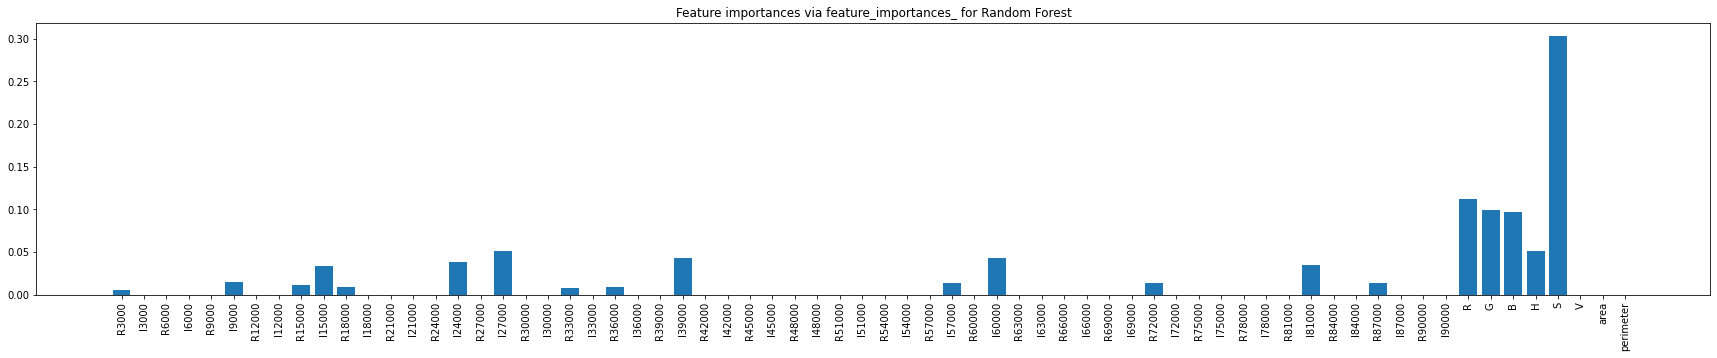

[INFO] Finding best model parameters with reduced x_train
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 12}
[INFO] Best score: 0.873
[INFO] Reducing input data based on best model
[INFO] Number of removed inputs: 0
[INFO] Inputs can not be further reduced!


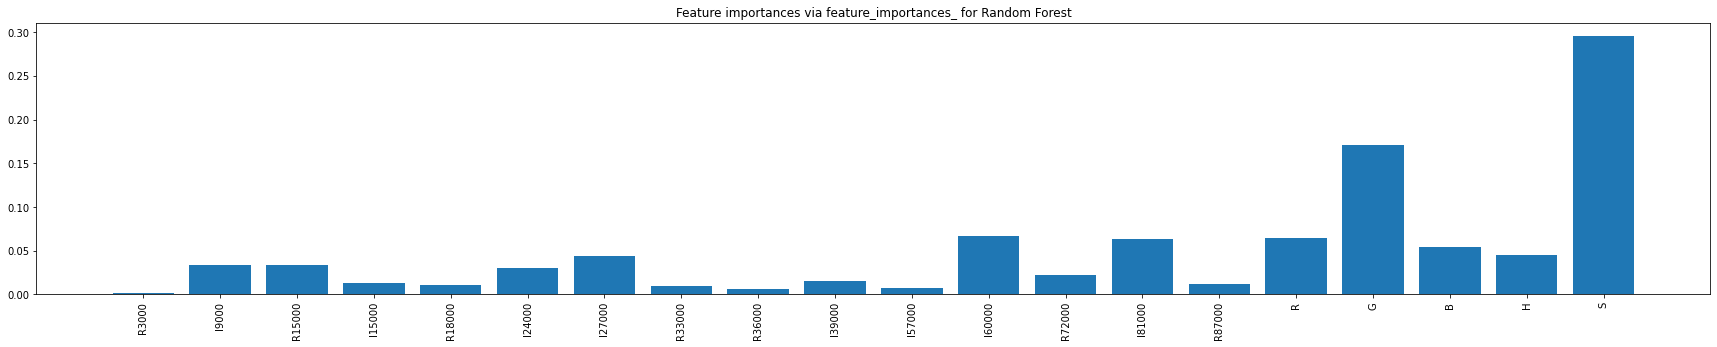

[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model
[INFO] Best parameter: {'model__max_features': 5, 'model__n_estimators': 12}
[INFO] Best score: 0.873
[[25  3]
 [ 2 19]]
F1 score	Purity		Recovery
0.8837		0.8636		0.9048


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [137]:
best_results = []
model_check = []
best_features = []
print("[INFO] CODE START")
for key in uploaded:
    best_model_list = []  
    best_features = []
    reduction_mode = False

    print("File uploaded: " +str(key))
    loaded_file = pd.read_csv(io.BytesIO(uploaded[key]))

    x_train_df = loaded_file.drop(['Label'], axis='columns')
    x_train = x_train_df.copy()
    y_train = loaded_file.Label

    #calcualte the largest possible cross validation
    number_of_cv_folds = StratifiedKFold(calculate_cross_validation_value(y_train))
    print("[INFO] Number of CV folds: " + str(number_of_cv_folds))

    #Calualte the all feature combinations and create list for vaible combinations
    max_featutures_var, n_estitmators_var = testing_combination_arrays(x_train, 20)
    print("[INFO] N_estimators combinations: " + str(n_estitmators_var))
    print("[INFO] max_feature combinations: " + str(max_featutures_var))

    while(reduction_mode==False):
      #Perform grid search for Random Forest 
      print("[INFO] Finding best model parameters with reduced x_train")
      best_model_details, best_paramater = grid_search_RF_function(x_train, y_train, n_estitmators_var, max_featutures_var, number_of_cv_folds)

      best_model_list.append(best_model_details)

    
      #Reduce input data
      print("[INFO] Reducing input data based on best model")
      reduction_mode, x_train, x_train_df = reduce_input(x_train, y_train, number_of_cv_folds, best_paramater, x_train_df)
      best_features.append(x_train_df.columns)


    print("[INFO] Input reduced to lowest combination. Aquiring best parameters and testing model")
    best_model_details, best_paramater = grid_search_RF_function(x_train, y_train, n_estitmators_var, max_featutures_var, number_of_cv_folds)

    best_model_list.append(best_model_details)

    model_check = best_model_test(x_train, y_train, number_of_cv_folds, best_paramater, best_results, x_train_df)
    
    with open(str(key) + '_random_forest' +  '.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerows(best_model_list)
        writer.writerow(model_check_header)
        writer.writerows(model_check)
        writer.writerow(best_features_header)
        writer.writerows(best_features)

    files.download(str(key) + '_random_forest' + '.csv') 
